# Nguyễn Đỗ Hoàng Nga - 23. Xây dựng  mô hình dự báo giá nhà trên/m2 
# của bài toán mua bán nhà mặt phố Quận Ba Đình

In [39]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

### CHOSING TARGET DATA

In [40]:
data = pd.read_csv("D:\DA-Class\DA2212R1\End_of_term\RoadSurfaceHouseTrading.csv")
print(data.columns)
print(data.shape)

Index(['Unnamed: 0', 'dien_tich', 'huong_ban_cong', 'phong_ngu',
       'id_thanh_pho', 'ten_thanh_pho', 'id_quan', 'ten_quan', 'so_tang',
       'mat_tien', 'noi_that', 'huong_nha', 'so_do', 'lat', 'long', 'gia',
       'gia_m2', 'du_an', 'project_name', 'id_duong', 'ten_duong',
       'do_rong_duong', 'do_rong_duong_ml', 'id_phuong', 'ten_phuong'],
      dtype='object')
(62847, 25)


In [41]:
#Chọn dữ liệu của quận Ba Đình
data_target = data[data["id_quan"] == "5e5501caeb80a7245175de1a"]
data_target.shape

(4969, 25)

In [42]:
# Mô tả dữ liệu target

data_target.describe()

,Unnamed: 0,dien_tich,phong_ngu,so_tang,mat_tien,lat,long,gia,gia_m2,do_rong_duong
count,4969.000000,4925.000000,2821.000000,3604.000000,1562.000000,4957.000000,4957.000000,4.804000e+03,4778.000000,1303.000000
mean,2485.000000,124.446564,13.534562,10.498335,8.514052,21.035606,105.823963,6.228145e+04,681.546143,18.536378
std,1434.571074,362.817339,253.354985,223.654794,26.262693,0.006399,0.012297,1.365624e+06,13743.641600,16.987857
min,1.000000,0.000000,1.000000,1.000000,2.000000,20.955835,105.748431,7.000000e-03,0.000200,1.000000
25%,1243.000000,51.000000,3.000000,4.000000,5.000000,21.031656,105.814133,1.200000e+04,208.333333,7.250000
50%,2485.000000,73.000000,4.000000,5.000000,6.000000,21.034570,105.820562,2.350000e+04,305.000000,15.000000
75%,3727.000000,110.000000,6.000000,6.000000,8.000000,21.040567,105.832811,4.200000e+04,435.000000,25.000000
max,4969.000000,14000.000000,9500.000000,9500.000000,999.000000,21.050173,105.863626,9.424000e+07,772727.272727,200.000000


## STEP 1: DATA CLEANING

In [43]:
# Loại bỏ dữ liệu khuyết thiếu ít nhất 2 trong 3 thuộc tính 'dien_tich', 'gia', 'gia_m2'
 
data_target1 = data_target.dropna(subset=['dien_tich', 'gia', 'gia_m2'], thresh=2)

# % số lượng bản ghi còn lại
100 * data_target1.shape[0]/data_target.shape[0]

96.37754075266653

In [44]:
# ĐIỀN CÁC GIÁ TRỊ KHUYẾT THIẾU

#Dien gia tri do_rong_duong bang mean của cùng 1 con duong
data_target1['do_rong_duong'] = data_target1.groupby('id_duong')['do_rong_duong'].apply(lambda x: x.fillna(x.mean()))  

# Dùng công thức gia = gia_m2*dien_tich để điền giá trị khuyết thiếu của cột
data_target1['gia'] = data_target1['gia'].fillna(data_target1['gia_m2'] * data_target1['dien_tich'])

data_target1['gia_m2'] = data_target1['gia_m2'].fillna(data_target1['gia'] / data_target1['dien_tich'])

data_target1['dien_tich'] = data_target1['dien_tich'].fillna(data_target1['gia'] / data_target1['gia_m2'])

# Dùng hàm nội suy để lấy ra giá trị có các thông số tương đồng từ các dữ liệu khác
data_target1['mat_tien'] = data_target1['mat_tien'].interpolate()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4308\1748761758.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_target1['do_rong_duong'] = data_target1.groupby('id_duong')['do_rong_duong'].apply(lambda x: x.fillna(x.mean()))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4308\1748761758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_target1['do_rong_duong'] = data_target1.groupby('id_duong

### FEATURES SELECTION

In [45]:
# Chọn ra 5 features ảnh hưởng đến "gia_m2" của nhà mặt phố
feature_data = data_target1[["dien_tich", "mat_tien", "gia_m2","so_do", "do_rong_duong", "ten_duong"]]
feature_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4789 entries, 1 to 4969
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dien_tich      4789 non-null   float64
 1   mat_tien       4788 non-null   float64
 2   gia_m2         4789 non-null   float64
 3   so_do          3274 non-null   object 
 4   do_rong_duong  4619 non-null   float64
 5   ten_duong      4658 non-null   object 
dtypes: float64(4), object(2)
memory usage: 261.9+ KB


In [46]:
# Hàm kiểm tra chuoi trong cot so_do
def check_string(string, info):
    for word in info:
        if word in info:
            return True
    return False

In [47]:
# Gán các giá trị 'chua so', 'co so', 'KXĐ' vào cột so_do
feature_data['so_do'].fillna("KXĐ", inplace = True)
for id, row in feature_data.iterrows():
    feature_data.at[id, 'so_do'] = row['so_do'].lower()
    tmp_info = ""
    if check_string(row['so_do'],'chua')| check_string(row['so_do'],'ban giao') | check_string(row['so_do'],'cho lam'):
        tmp_info = tmp_info + "Chưa sổ"
    if check_string(row['so_do'],'co so') | check_string(row['so_do'],'chinh_chu') | check_string(row['so_do'],'day du') |check_string(row['so_do'],'so do'):
        tmp_info = "Có sổ"
    else:    tmp_info = "KXĐ"
    feature_data.at[id, 'so_do'] = tmp_info

feature_data['so_do'].unique()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4308\2824898913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data['so_do'].fillna("KXĐ", inplace = True)


array(['Có sổ'], dtype=object)

In [48]:
#Thông tin dữ liệu sau khi điền dữ liệu cho cột "So_do"
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4789 entries, 1 to 4969
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dien_tich      4789 non-null   float64
 1   mat_tien       4788 non-null   float64
 2   gia_m2         4789 non-null   float64
 3   so_do          4789 non-null   object 
 4   do_rong_duong  4619 non-null   float64
 5   ten_duong      4658 non-null   object 
dtypes: float64(4), object(2)
memory usage: 390.9+ KB


In [49]:
#Xóa lần nữa các dòng còn dữ liệu khuyết thiếu
feature_data1 = feature_data.dropna()
feature_data1 = feature_data1.reset_index(drop=True)

feature_data1.info()

# % số lượng bản ghi còn lại
print("--------------------------")
print("Số lượng % bản ghi còn lại:")
100 * feature_data1.shape[0]/data_target.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4619 entries, 0 to 4618
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dien_tich      4619 non-null   float64
 1   mat_tien       4619 non-null   float64
 2   gia_m2         4619 non-null   float64
 3   so_do          4619 non-null   object 
 4   do_rong_duong  4619 non-null   float64
 5   ten_duong      4619 non-null   object 
dtypes: float64(4), object(2)
memory usage: 216.6+ KB
--------------------------
Số lượng % bản ghi còn lại:


92.95632924129603

### Xóa dữ liệu ngoại lai bằng IQR score

In [50]:
#Loại bỏ ngoại lai dien_tich
area_data = feature_data1['dien_tich'].values

q1 = np.percentile(area_data, 25)
q3 = np.percentile(area_data, 75)

print(area_data.max(), area_data.min())
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print(lower_bound, upper_bound)

outlier_area_data = feature_data1[(feature_data1['dien_tich'] >= lower_bound) & (feature_data1['dien_tich'] <= upper_bound)]
print(outlier_area_data.shape)


14000.0 0.0
-37.5 198.5
(4226, 6)


In [51]:
#Loại bỏ ngoại lai gia_m2
priem2_data = feature_data1['gia_m2'].values

q1 = np.percentile(priem2_data, 25)
q3 = np.percentile(priem2_data, 75)

print(priem2_data.max(), priem2_data.min())
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print(lower_bound, upper_bound)

outlier_pricem2_data = feature_data1[(feature_data1['gia_m2'] >= lower_bound) & (feature_data1['gia_m2'] <= upper_bound)]

print(outlier_pricem2_data.shape)

inf 0.000199999999999
-131.9616977225673 780.1293995859213
(4542, 6)


In [52]:
#Loại bỏ ngoại lai mat_tien
surface_data = feature_data1['mat_tien'].values

q1 = np.percentile(surface_data, 25)
q3 = np.percentile(surface_data, 75)

print(surface_data.max(), surface_data.min())
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print(lower_bound, upper_bound)

outlier_surface_data = feature_data1[(feature_data1['mat_tien'] >= lower_bound) & (feature_data1['mat_tien'] <= upper_bound)]

print(outlier_surface_data.shape)

999.0 2.0
0.22279143897996345 12.666325136612022
(4308, 6)


In [53]:
#Loại bỏ ngoại lai do_rong_duong
road_width_data = feature_data1['do_rong_duong'].values

q1 = np.percentile(road_width_data, 25)
q3 = np.percentile(road_width_data, 75)

print(road_width_data.max(), road_width_data.min())
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print(lower_bound, upper_bound)

outlier_road_width_data = feature_data1[(feature_data1['do_rong_duong'] >= lower_bound) & (feature_data1['do_rong_duong'] <= upper_bound)]

print(outlier_road_width_data.shape)

200.0 1.0
-2.723837209302326 38.8343023255814
(4441, 6)


In [54]:
# merge 4 DataFrame
merged_df = pd.merge(outlier_area_data, outlier_pricem2_data, how='inner')
merged_df = pd.merge(merged_df, outlier_surface_data, how='inner')
merged_df = pd.merge(merged_df,outlier_road_width_data, how='inner')

# giữ lại một bản ghi nếu trùng nhau
merged_df = merged_df.drop_duplicates()

print("Merge 4 df removed outlier")
print(merged_df.shape)

# % số lượng bản ghi còn lại
print("--------------------------")
print("Số lượng % bản ghi còn lại:")
100 * merged_df.shape[0]/data_target.shape[0]

Merge 4 df removed outlier
(3592, 6)
--------------------------
Số lượng % bản ghi còn lại:


72.28818675789897

## STEP 2: DATA TRANSFORMATION

### Min-Max scaling 
### RobustScaler scaling

In [117]:
# Chuẩn hóa dữ liệu dien_tich với minmax scaling
scaler = MinMaxScaler()

merged_df[['dien_tich_s']] = scaler.fit_transform(merged_df[['dien_tich']])

merged_df[['gia_m2_s']] = scaler.fit_transform(merged_df[['gia_m2']])

merged_df[['do_rong_duong_s']] = scaler.fit_transform(merged_df[['do_rong_duong']])

In [60]:
# Chuẩn hóa dữ liệu mat_tien với robust scaling
scaler = RobustScaler()

merged_df[['mat_tien_s']] = scaler.fit_transform(merged_df[['mat_tien']])

# mô tả dữ liệu sau chuẩn hóa
pd.DataFrame(merged_df[['mat_tien_s']]).describe()

,mat_tien_s
count,3592.000000
mean,0.175099
std,0.721454
min,-1.421782
25%,-0.363217
50%,0.000000
75%,0.636783
max,2.670644


In [121]:
# mã hóa cột so_do với Label encoder 
merged_df['so_do_encoded'] = merged_df['so_do'].astype('category').cat.codes
merged_df


,dien_tich,mat_tien,gia_m2,so_do,do_rong_duong,ten_duong,dien_tich_s,gia_m2_s,mat_tien_s,do_rong_duong_s,ten_duong_encoded,gia_nha_predicted,so_do_encoded
0,69.0,8.300,304.347826,Có sổ,14.913043,Đường Nguyễn Công Hoan,0.313830,0.392707,0.999090,0.376028,53,0.390500,0
1,50.0,7.150,500.000000,Có sổ,20.200000,Đường Trần Phú,0.212766,0.645161,0.557185,0.518919,74,0.418456,0
2,50.0,5.000,320.000000,Có sổ,4.000000,Đường Hồng Hà,0.212766,0.412903,-0.268986,0.081081,45,0.258233,0
3,50.0,5.000,320.000000,Có sổ,4.000000,Đường Lê Hồng Phong,0.212766,0.412903,-0.268986,0.081081,47,0.257812,0
259,90.0,9.375,333.333333,Có sổ,30.000000,Phố Liễu Giai,0.425532,0.430107,1.412175,0.783784,19,0.556051,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247027,50.0,6.500,460.000000,Có sổ,15.323077,Đường Cửa Bắc,0.212766,0.593548,0.307412,0.387110,41,0.375304,0
247028,60.0,6.000,120.000000,Có sổ,4.000000,Đường Đào Tấn,0.265957,0.154838,0.115280,0.081081,82,0.262163,0
247029,69.0,5.000,359.420290,Có sổ,6.000000,Phố Trấn Vũ,0.313830,0.463768,-0.268986,0.135135,31,0.288879,0
247030,85.0,4.500,185.882353,Có sổ,12.000000,Đường Hoàng Hoa Thám,0.398936,0.239848,-0.461118,0.297297,43,0.346526,0


In [122]:
# các giá trị ở cột ten_duong
merged_df['ten_duong'].unique()

array(['Đường Nguyễn Công Hoan', 'Đường Trần Phú', 'Đường Hồng Hà',
       'Đường Lê Hồng Phong', 'Phố Liễu Giai', 'Đường Đội Cấn',
       'Đường Hoàng Hoa Thám', 'Phố Đốc Ngữ', 'Đường Lạc Chính',
       'Phố Phạm Huy Thông', 'Phố Linh Lang', 'Đường Giang Văn Minh',
       'Phố Sơn Tây', 'Đường Đào Tấn', 'Đường Văn Cao', 'Đường Bưởi',
       'Phố An Xá', 'Đường Ngọc Hà', 'Phố Kim Mã', 'Đường Trúc Bạch',
       'Phố Láng Hạ', 'Đường Cầu Giấy', 'Đường Phan Kế Bính',
       'Đường Đội Nhân', 'Đường Quán Thánh', 'Đường Phúc Xá',
       'Đường Nguyễn Chí Thanh', 'Phố Trấn Vũ', 'Phố Giảng Võ',
       'Phố Kim Mã Thượng', 'Đường Núi Trúc', 'Đường Nguyễn Trung Trực',
       'Phố Châu Long', 'Phố Nghĩa Dũng', 'Đường Trần Tế Xương',
       'Đường Điện Biên Phủ', 'Đường Nguyễn Biểu', 'Đường Vạn Bảo',
       'Đường Vĩnh Phúc', 'Đường Đê La Thành', 'Đường Thụy Khuê',
       'Phố Ngũ Xã', 'Đường Cửa Bắc', 'Đường Nguyễn Huy Thông',
       'Phố Hàng Bún', 'Đường Quần Ngựa', 'Phố Nam Cao', 'Đường Lê Tr

In [123]:
# mã hóa cột ten_duong với Label encoder sử dụng pandas
merged_df['ten_duong_encoded'] = merged_df['ten_duong'].astype('category').cat.codes
merged_df

,dien_tich,mat_tien,gia_m2,so_do,do_rong_duong,ten_duong,dien_tich_s,gia_m2_s,mat_tien_s,do_rong_duong_s,ten_duong_encoded,gia_nha_predicted,so_do_encoded
0,69.0,8.300,304.347826,Có sổ,14.913043,Đường Nguyễn Công Hoan,0.313830,0.392707,0.999090,0.376028,53,0.390500,0
1,50.0,7.150,500.000000,Có sổ,20.200000,Đường Trần Phú,0.212766,0.645161,0.557185,0.518919,74,0.418456,0
2,50.0,5.000,320.000000,Có sổ,4.000000,Đường Hồng Hà,0.212766,0.412903,-0.268986,0.081081,45,0.258233,0
3,50.0,5.000,320.000000,Có sổ,4.000000,Đường Lê Hồng Phong,0.212766,0.412903,-0.268986,0.081081,47,0.257812,0
259,90.0,9.375,333.333333,Có sổ,30.000000,Phố Liễu Giai,0.425532,0.430107,1.412175,0.783784,19,0.556051,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247027,50.0,6.500,460.000000,Có sổ,15.323077,Đường Cửa Bắc,0.212766,0.593548,0.307412,0.387110,41,0.375304,0
247028,60.0,6.000,120.000000,Có sổ,4.000000,Đường Đào Tấn,0.265957,0.154838,0.115280,0.081081,82,0.262163,0
247029,69.0,5.000,359.420290,Có sổ,6.000000,Phố Trấn Vũ,0.313830,0.463768,-0.268986,0.135135,31,0.288879,0
247030,85.0,4.500,185.882353,Có sổ,12.000000,Đường Hoàng Hoa Thám,0.398936,0.239848,-0.461118,0.297297,43,0.346526,0


In [124]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3592 entries, 0 to 247031
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dien_tich          3592 non-null   float64
 1   mat_tien           3592 non-null   float64
 2   gia_m2             3592 non-null   float64
 3   so_do              3592 non-null   object 
 4   do_rong_duong      3592 non-null   float64
 5   ten_duong          3592 non-null   object 
 6   dien_tich_s        3592 non-null   float64
 7   gia_m2_s           3592 non-null   float64
 8   mat_tien_s         3592 non-null   float64
 9   do_rong_duong_s    3592 non-null   float64
 10  ten_duong_encoded  3592 non-null   int8   
 11  gia_nha_predicted  3592 non-null   float64
 12  so_do_encoded      3592 non-null   int8   
dtypes: float64(9), int8(2), object(2)
memory usage: 343.8+ KB


## STEP 3: MODEL

In [67]:
import matplotlib.pyplot as plt

### DATASET

### PP1. Tính toán ma trận tương quan giữa hai biến

In [125]:


correlation_matrix1 = merged_df[['dien_tich_s', 'gia_m2_s']].corr()
print(correlation_matrix1)

correlation_matrix2 = merged_df[['mat_tien_s', 'gia_m2_s']].corr()
print(correlation_matrix2)

correlation_matrix3 = merged_df[['do_rong_duong_s', 'gia_m2_s']].corr()
print(correlation_matrix3)

correlation_matrix4 = merged_df[['ten_duong_encoded', 'gia_m2_s']].corr()
print(correlation_matrix4)

correlation_matrix4 = merged_df[['so_do_encoded', 'gia_m2_s']].corr()
print(correlation_matrix4)


             dien_tich_s  gia_m2_s
dien_tich_s     1.000000  0.175161
gia_m2_s        0.175161  1.000000
            mat_tien_s  gia_m2_s
mat_tien_s    1.000000  0.108801
gia_m2_s      0.108801  1.000000
                 do_rong_duong_s  gia_m2_s
do_rong_duong_s         1.000000  0.402382
gia_m2_s                0.402382  1.000000
                   ten_duong_encoded  gia_m2_s
ten_duong_encoded           1.000000 -0.164152
gia_m2_s                   -0.164152  1.000000
               so_do_encoded  gia_m2_s
so_do_encoded            NaN       NaN
gia_m2_s                 NaN       1.0


KL: 
Giá trị diện tích và giá m2 có tương quan dương nhẹ (0.174), tuy nhiên đây không phải là một tương quan mạnh.
Giá m2 và mặt tiền cũng có tương quan dương nhẹ (0.111).
Giá m2 và độ rộng đường có tương quan dương khá mạnh (0.406), nếu giá trị của một biến tăng thì giá trị của biến kia cũng tăng

### PP2. Phân tích hồi quy tuyến tính

In [101]:
# Prepare dataset
X = merged_df[['dien_tich_s', 'mat_tien_s', 'do_rong_duong_s', 'ten_duong_encoded']].values  #Do tham số so_do chưa ra được giá trị mong muốn nên tạm bỏ tham số đó trong việc xây mô hình
y = merged_df['gia_m2_s'].values  

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 19)

In [127]:
#Tạo mô hình hồi quy tuyến tính và fit dữ liệu:

reg = LinearRegression()    
reg.fit(X_train, y_train)

# Đánh giá độ mạnh của mô hình:
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('MSE = ', mse)
print('R2 score = ', r2)
print("MAPE:", mape)

MSE =  0.02974756992482738
R2 score =  0.19477873625530318
MAPE: 8210.680072877352


### PP3.  Phân tích mô hình đa biến

In [126]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test) 

mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

print(results.summary())

MAPE: 8210.680072877365
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     148.0
Date:                Mon, 17 Apr 2023   Prob (F-statistic):          3.58e-115
Time:                        15:18:55   Log-Likelihood:                 1015.1
No. Observations:                2873   AIC:                            -2020.
Df Residuals:                    2868   BIC:                            -1990.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2318      0

### PP4. Mô hình hồi quy phi tuyến

In [128]:

from sklearn.preprocessing import PolynomialFeatures

# Khởi tạo đối tượng PolynomialFeatures với bậc là 2
poly = PolynomialFeatures(degree=2)

# Biến đổi các biến đầu vào thành các biến phi tuyến
X_poly = poly.fit_transform(X_test)

# Khởi tạo mô hình hồi quy tuyến tính
model = LinearRegression()

# Thực hiện phân tích hồi quy phi tuyến
model.fit(X_poly, y_test)

# In hệ số ước lượng
print(model.coef_)

# Tính dự đoán giá nhà
y_pred = model.predict(X_poly)

# Tính MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

print("MAPE:", mape)

[ 0.00000000e+00  5.38802232e-14  1.38503594e-01  1.66362188e-02
  9.92913515e-02 -1.03425862e-03  7.63278329e-17  1.38503594e-01
  1.66362188e-02  9.92913515e-02 -1.03425862e-03 -2.69492629e-01
  3.16852017e-02  7.95044419e-02 -1.68085737e-04 -1.16596006e-02
  4.15776044e-02 -3.33794069e-04 -1.94952323e-02  4.19807692e-03
  2.80814504e-06]
MAPE: 7410.673375444853


In [130]:
### Các phương pháp đánh giá thêm về độ chính xác và độ tin cậy của dự đoán trong mô hình hồi quy (Thử làm thêm xem sao)
# 1.Mean Squared Error (MSE):
# 2. Kiểm định nhiễu Outlier

# Tính độ lệch chuẩn của dữ liệu giá nhà
std_gia1 = np.std(merged_df['gia_m2_s'])  # sử dụng NumPy
std_gia2 = merged_df['gia_m2_s'].std()   # sử dụng pandas

# In ra độ lệch chuẩn
print("Độ lệch chuẩn của giá nhà là:", std_gia1, std_gia2)

Độ lệch chuẩn của giá nhà là: 0.18784993278859574 0.18787608662551866


## STEP 4 - VISUALIZATION

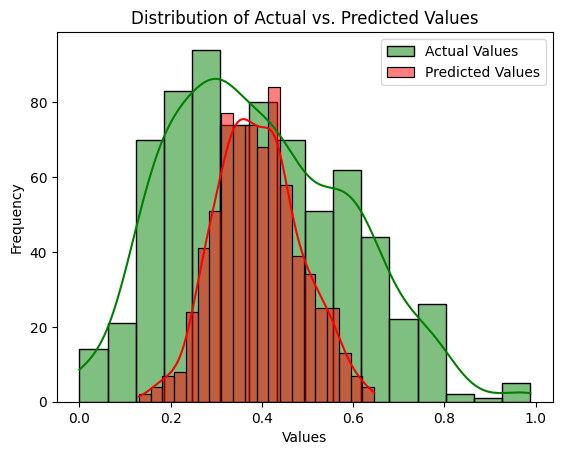

In [143]:
# Distribution plot 
sns.histplot(y_test, color='green', label='Actual Values', kde=True)
sns.histplot(y_pred, color='red', label='Predicted Values', kde=True)
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Distribution of Actual vs. Predicted Values")
plt.legend()
plt.show()

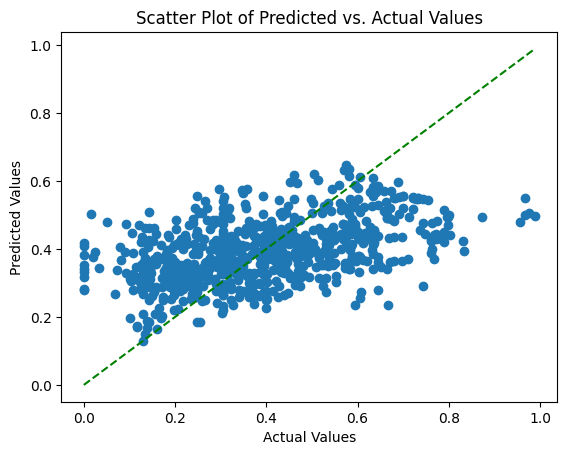

In [140]:
# Scatter plot
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='green', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of Predicted vs. Actual Values")
plt.show()

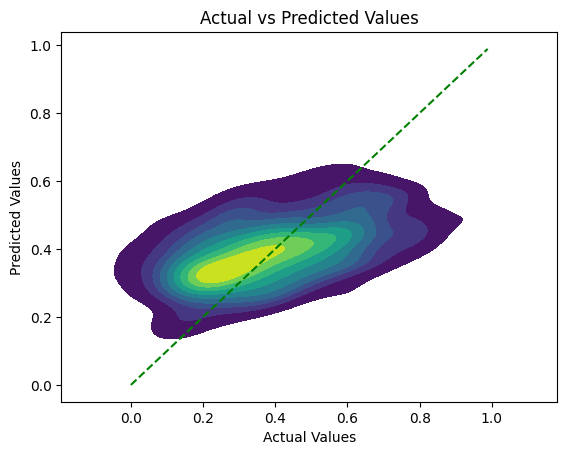

In [136]:
# Create a scatter plot
# sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

# Add a diagonal line from (min, min) to (max, max) for reference
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='green', linestyle='--')

# Set the x-axis and y-axis labels
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Set the title of the plot
plt.title('Actual vs Predicted Values')

# Create a heat map to show the density of points
sns.kdeplot(x=y_test, y=y_pred, cmap='viridis', fill=True)

# Show the plot
plt.show()